In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.cluster import KMeans
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
#Function for Updating Covariance(Assumed to be correct)
#Function to update Covariance
def update(x_new,S,mean_old,n):
  temp = np.multiply(mean_old,n-1)
  temp = np.add(temp,x_new)
  mean_new = np.divide(temp,n) #evaluating updated mean

  #Next we will evaluate M_t
  temp = np.subtract(mean_old,mean_new)
  M_t = np.outer(temp,temp)

  #Evaluating delta_t
  temp = np.subtract(x_new,mean_new)
  delta_t = np.outer(temp,temp)

  #Evaluating S_t
  temp = np.multiply(M_t,n-1)
  temp = np.add(temp, delta_t)
  temp2 = np.multiply(S,n-2)
  S_t = np.add(temp2,temp)
  S_t = np.divide(S_t,n-1)

  return S_t , mean_new

In [3]:
#Test for update function
x_new = [-2,3.1]
S = [[1,2],[-1,3]]
mean_old = [6.2,3.9]
n = 2000000
S_new , mean_new = update(x_new,S,mean_old,n)

In [4]:
S_new

array([[ 1.00003312,  2.00000228],
       [-0.99999622,  2.99999882]])

In [5]:
mean_new

array([6.1999959, 3.8999996])

Test Check for Update function completed. It looks alright to me. Although possible hickup when n = 1. Check the boundary cases in the main function.

In [6]:
from scipy.spatial import distance

In [7]:
#Function to find mohalanobis distance of a point from a distribution
distance.mahalanobis(x_new,mean_new,np.linalg.pinv(S_new))

6.257732311486527

In [8]:
#Test of Significance for Mohalanobis Distance
from scipy.stats import chi2

In [9]:
1 - chi2.cdf(distance.mahalanobis(x_new,mean_new,np.linalg.pinv(S_new)), 1) #As degrees of freedom = 2-1 = 1

0.012365238318656324

We can use this p-value check to detect outliers and run the program again

In [10]:
#Function-1: Finding the closest cluster of a point given the point and centroids
def find_closest_cluster(x, centroids, S):
    K = len(centroids)
    md = np.zeros(K)
    for k in range(K): # no. clusters
        md[k] = distance.mahalanobis(x,centroids[k],np.linalg.pinv(S[k]))
        #print(md[k])
    out = [np.argmin(md),1 - chi2.cdf(np.min(md),len(centroids[0]))]
    return out

#Function-2: Calculating Euclidean Norm
def norm(v):
    temp = 0
    for i in range(len(v)):
        temp = temp + (v[i]**2)
    temp = temp**0.5
    return temp

In [15]:
x = [3,9]
S = iden_array(2,4)
centroids = np.random.multivariate_normal([0,0],np.eye(2),4)

a,b = find_closest_cluster(x,centroids,S)
print(a)
print(b)

3
0.015182350452442761


In [40]:
centroids[0]

array([ 0.6900738 , -0.78491131])

These two functions are good but just for precaution use normalized datasets so that the distances doesn't become more than 999999

In [12]:
def multi_cov(se,d):
  o = []
  for i in range(len(se)):
    m = np.mean(se[i],0)
    n = len(se[i])
    t = np.zeros((d,d))
    for j in range(n):
      temp = np.subtract(se[i][j],m)
      temp1 = np.transpose(temp)
      temp = np.matmul(temp,temp1)
      t = np.add(t,temp)
    t = np.divide(t,n-1)
    o = o + [t]
  return o

In [13]:
def empty_array(K):
  o = []
  for i in range(K):
    o = o + [[]]
  return o

In [14]:
#Function to get array of identity matrix of a particular size
def iden_array(d,k):
  o = []
  for i in range(k):
    o = o + [np.eye(d)]
  return o

In [16]:
#Function-6: Finding E_K for general setting
def eK(K,X):
    if len(X)<K:
        print("length is an issue")
    else:
        centroids = X[:K]
        counter = np.ones(K)
        p = np.zeros(K)
        temp_len = len(X) - K
        eK = np.zeros(temp_len)
        y = len(X[K])
        temp_len = (K,y)
        g = np.zeros(temp_len)
        S = iden_array(len(X[0]),K)
        for j in range(K,len(X),1):      
            out = find_closest_cluster(X[j],centroids,S)
            closest_K = out[0]
            pval = out[1]
            m = counter.copy()
            temp_centroids = centroids.copy()
            counter[closest_K] +=1
            S, temp_centroids[closest_K] = update(X[j],S,temp_centroids[closest_K],counter[closest_K])
            temp3 = np.subtract(counter,m)
            
            if pval <0.05:
                for i in range(K):
                #print("Cluster " + str(i))
                    temp1 = np.subtract(centroids[i],temp_centroids[i])
                
                    temp1 = np.transpose(temp1)
                    q = np.matmul(temp1,g[i])
                    #print(q[i])
                    b = norm(np.subtract(centroids[i],temp_centroids[i]))**2
                    #print(b[i])
                    a = temp3[i] * (norm(np.subtract(X[j],temp_centroids[i]))**2)
                    #print(a[i])
                    p[i] = p[i] + (2*q) + (b*m[i]) + a
                #print(p[i])
                    
                    g[i] = g[i] + np.multiply(m[i],np.subtract(centroids[i],temp_centroids[i])) + np.multiply(temp3[i],np.subtract(X[j],temp_centroids[i]))
                    
            elif (pval<0.1 and pval>0.05) or counter[closest_K]<200:
                for i in range(K):
                #print("Cluster " + str(i))
                    temp1 = np.subtract(centroids[i],temp_centroids[i])

                    temp1 = np.transpose(temp1)
                    q = np.matmul(temp1,g[i])
                    #print(q[i])
                    b = norm(np.subtract(centroids[i],temp_centroids[i]))**2
                    #print(b[i])
                    a = temp3[i] * (norm(np.subtract(X[j],temp_centroids[i]))**2)
                    #print(a[i])
                    p[i] = p[i] + (2*q) + (b*m[i]) + a
                    #print(p[i])
                    g[i] = g[i] + np.multiply(m[i],np.subtract(centroids[i],temp_centroids[i])) + np.multiply(temp3[i],np.subtract(X[j],temp_centroids[i]))

                
            
            #update stage
            
            centroids = temp_centroids.copy()
        
        
            eK[j-K] = np.sum(p)
        return eK

In [17]:
def find_closest_cluster1(x, centroids):
    closest_cluster, closest_distance = 999999, 999999 # initially invalid
    K = len(centroids)
    for k in range(K): # no. clusters
        temp = 0
        for j in range(len(centroids[k])):
            temp = temp + (x[j]-centroids[k][j])**2
        distance = temp # Euclidean distance
        if distance < closest_distance:
            closest_cluster  = k
            closest_distance = distance
    return closest_cluster

In [18]:
def dmax(K,X):
    if len(X)<K:
        print("length is an issue")
    else:
        d = []
        centroids = X[:K]
        counter = np.ones(K)
        for x_n in X[K:]:
            closest_k = find_closest_cluster1(x_n,centroids)
            counter[closest_k] +=1
            temp = np.subtract(x_n,centroids[closest_k])
            temp = np.divide(temp,counter[closest_k])
            centroids[closest_k] = np.add(centroids[closest_k],temp)
            for h in range(len(centroids)):
                temp2 = 0
                for x in range(len(centroids)):
                    v = np.linalg.norm(np.subtract(centroids[h],centroids[x]))
                    if v>temp2:
                        temp2 = v
            d = d + [temp2]
        return d

In [33]:
#Function-8: Generating plot for I2-I11 in general setting
def final(name,data):
    t = np.divide(eK(1,data)[1:],eK(2,data))
    d = dmax(2,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/4
    I2= t

    t = np.divide(eK(1,data)[2:],eK(3,data))
    d = dmax(3,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/9
    I3= t
    t = np.divide(eK(1,data)[3:],eK(4,data))
    d = dmax(4,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/16
    I4= t  
    t = np.divide(eK(1,data)[4:],eK(5,data))
    d = dmax(5,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/25
    I5= t
    t = np.divide(eK(1,data)[5:],eK(6,data))
    d = dmax(6,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/36
    I6 = t
    t = np.divide(eK(1,data)[6:],eK(7,data))
    d = dmax(7,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/49
    I7= t
    t = np.divide(eK(1,data)[7:],eK(8,data))
    d = dmax(8,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/64
    I8= t
    t = np.divide(eK(1,data)[8:],eK(9,data))
    d = dmax(9,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/81
    I9= t
    t = np.divide(eK(1,data)[9:],eK(10,data))
    d = dmax(10,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/100
    I10= t
    t = np.divide(eK(1,data)[10:],eK(11,data))
    d = dmax(11,data)
    t = np.multiply(t,np.multiply(d,d))
    t = t/121
    I11= t

    I2 = I2[9:]
    I3 = I3[8:]
    I4 = I4[7:]
    I5 = I5[6:]
    I6 = I6[5:]
    I7 = I7[4:]
    I8 = I8[3:]
    I9 = I9[2:]
    I10 = I10[1:]
    
    temp = [I2,I3,I4,I5,I6,I7,I8,I9,I10,I11]
    temp = np.asarray(temp)
    temp2 = np.argmax(temp, axis=0)

    temp2 = np.add(temp2,np.repeat(2,len(temp2)))


    plt.plot(temp2,label = "Expected cluster number: SK-mean")


    plt.legend()

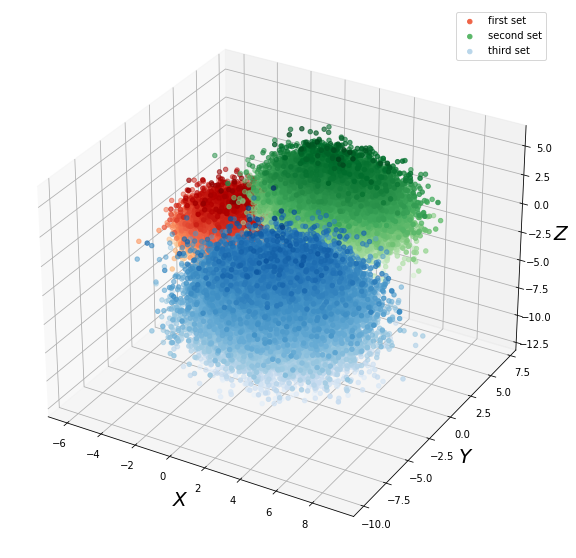

In [27]:
np.random.seed(1908)
ax = plt.axes(projection='3d')
mean1 = [-2,0,-2]
mean2 = [2.1,3,0]
mean3 = [2,-3.02,-5]
var1 = [[1,0,0],[0,1,0],[0,0,1]]
var2 = [[2,0,0],[0,1,0],[0,0,2]]
var3 = [[3,0,0],[0,3,0],[0,0,3]]
for i in range(1):
    data1_x,data1_y,data1_z = np.random.multivariate_normal(mean1,var1,50000).T
for i in range(1):
    data2_x,data2_y,data2_z = np.random.multivariate_normal(mean2,var2,50000).T
for i in range(1):
    data3_x,data3_y,data3_z = np.random.multivariate_normal(mean3,var3,50000).T
ax.scatter3D(data1_x, data1_y, data1_z, c=data1_z, label = "first set",cmap = "OrRd")
ax.scatter3D(data2_x, data2_y, data2_z, c=data2_z, label ='second set',cmap = "Greens")
ax.scatter3D(data3_x, data3_y, data3_z, c=data3_z, label='third set',cmap = "Blues")
ax.set_xlabel('$X$', fontsize = 20)
ax.set_ylabel('$Y$',fontsize = 20)
ax.set_zlabel('$Z$',fontsize = 20)
ax.legend()
df = pd.DataFrame(data1_x,columns=["X-axis"])
df_temp = pd.DataFrame(data1_y,columns = ["Y-axis"])
df = pd.concat([df,df_temp],axis = 1)
df_temp = pd.DataFrame(data1_z,columns = ["Z-axis"])
df_1= pd.concat([df,df_temp],axis = 1)
#df_temp = pd.DataFrame(np.zeros(500),columns = ["Marker"])
#df_1 = pd.concat([df,df_temp],axis = 1)

df = pd.DataFrame(data2_x,columns=["X-axis"])
df_temp = pd.DataFrame(data2_y,columns = ["Y-axis"])
df = pd.concat([df,df_temp],axis = 1)
df_temp = pd.DataFrame(data2_z,columns = ["Z-axis"])
df_2= pd.concat([df,df_temp],axis = 1)
#df_temp = pd.DataFrame(np.ones(500),columns = ["Marker"])
#df_2 = pd.concat([df,df_temp],axis = 1)

df = pd.DataFrame(data3_x,columns=["X-axis"])
df_temp = pd.DataFrame(data3_y,columns = ["Y-axis"])
df = pd.concat([df,df_temp],axis = 1)
df_temp = pd.DataFrame(data3_z,columns = ["Z-axis"])
df_3= pd.concat([df,df_temp],axis = 1)
#df_temp = pd.DataFrame(np.repeat(2,500),columns = ["Marker"])
#df_3 = pd.concat([df,df_temp],axis = 1)


df = pd.concat([df_1,df_2,df_3])

s = pd.Series(range(150000))
df.set_index([s])
#df = df.sample(frac = 1) 
df.head()
data = df.to_numpy()

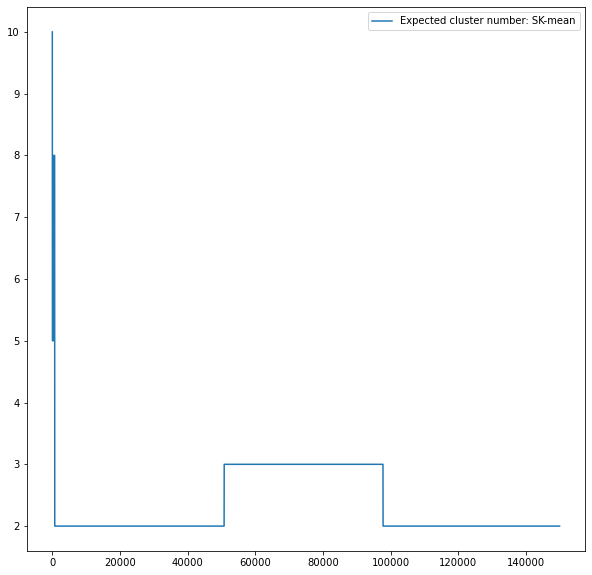

In [34]:
final("test",data)